*Universitat Politècnica De Catalunya · Barcelona Tech - UPC*

# EUNCET DATA 

## 1. Load the data.

This is the first step in our data's cleaning and preprocessing. We load all the sheets in the excel into different pandas dataframes. After we check if we can conect all the tables.

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
all_tables = pd.read_excel("DB_SARA_01.xlsx", sheet_name=None)

In [3]:
df_graduates = all_tables["TITULADOS"]
df_programs = all_tables["PROGRAMAS"]
df_students_courses = all_tables["QRY_EST_x_MAT"]
df_courses = all_tables["QRY_MAT_EXP"]
df_courses2 = all_tables["QRY_MATREC_EXP"]
df_students_info = all_tables["QRY_ESTUDIANTS"]
df_courses2.columns=df_courses2.iloc[0]
df_courses2 = df_courses2.iloc[1:]

In [5]:
graduated_student_code = list(df_graduates["CODI_EST"]) 
all_students_code = list(df_students_info["Num_id"])
print("Graduated students: ", len(set(graduated_student_code)))
print("All students: ",len(set(all_students_code)))

Graduated students:  723
All students:  2130


We check if the info of tuition of the different students is available 

In [6]:
len(df_students_courses[df_students_courses["CODI_EST"].apply(lambda x: x in graduated_student_code)]["CODI_EST"].unique())

723

In [6]:
len(df_students_courses[df_students_courses["CODI_EST"].apply(lambda x: x in all_students_code)]["CODI_EST"].unique())

2130

The following lines check how many student's grades we miss from the data in the two courses tables, we found that we only miss 106 student's course grades.

In [7]:
students_with_courses = df_courses[df_courses["CODI_EST"].apply(lambda x: x in all_students_code)]["CODI_EST"].unique()
print("Missing students in the first table: ", len(all_students_code)-len(students_with_courses))

Missing students in the first table:  106


In [8]:
not_courses = [i for i in all_students_code if i not in students_with_courses]
print("Number of students missing in the first table that are in the sencond: ",len(df_courses[df_courses["CODI_EST"].apply(lambda x: x in not_courses)]["CODI_EST"].unique()))

Number of students missing in the first table that are in the sencond:  0


## 2. Data combination.

In this step, we combine the different tables into a unique one where we are going to do all the data analysis and training the models.


We add to the students tuition table the code of the general grade course id and if it is graduated.

In [9]:
df_students_courses["CODI_PLA"] = df_students_courses["CODI_PRG"].apply(lambda x: list(df_programs[df_programs["CODI_PRG"]==x]["CODI_PLA"])[0])
df_students_courses["IS_GRADUATED"] = df_students_courses["CODI_EST"].apply(lambda x: x in graduated_student_code)
df_students_courses 

,CODI_EST,CODI_ANY_ACAD,CODI_PRG,CODI_MAT,CODI_PLA,IS_GRADUATED
0,100,1415,1027,19343,87,True
1,100,1516,1182,20719,87,True
2,588,1213,798,18413,87,False
3,588,1314,927,18696,87,False
4,588,1415,1027,19509,87,False
...,...,...,...,...,...,...
6309,114531,2122,2626,63872,208,False
6310,114532,2122,2626,64360,208,False
6311,114533,2122,2626,63814,208,False
6312,114534,2122,2639,63764,210,False


Find all the drop outs in our data, we basically achive that checking if the student is enrolled in the last year (21-22) or if it's the graduates table.

In [10]:
def get_drop_outs(codi_est, cod_any, is_graduated, df):
    if is_graduated or cod_any == 2122:
        return False
    elif len(df[df["CODI_EST"]==codi_est][df["CODI_ANY_ACAD"]==2122])> 0:
        return False 
    else: 
        return True
    
df_students_courses["IS_DROP_OUT"] = df_students_courses.apply(lambda x: 
                                     get_drop_outs(x.CODI_EST,x.CODI_ANY_ACAD,
                                     x.IS_GRADUATED, df_students_courses), axis=1)

df_students_courses

C:\Users\ahsin\AppData\Local\Temp\ipykernel_18340\2828996341.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  elif len(df[df["CODI_EST"]==codi_est][df["CODI_ANY_ACAD"]==2122])> 0:


,CODI_EST,CODI_ANY_ACAD,CODI_PRG,CODI_MAT,CODI_PLA,IS_GRADUATED,IS_DROP_OUT
0,100,1415,1027,19343,87,True,False
1,100,1516,1182,20719,87,True,False
2,588,1213,798,18413,87,False,True
3,588,1314,927,18696,87,False,True
4,588,1415,1027,19509,87,False,True
...,...,...,...,...,...,...,...
6309,114531,2122,2626,63872,208,False,False
6310,114532,2122,2626,64360,208,False,False
6311,114533,2122,2626,63814,208,False,False
6312,114534,2122,2639,63764,210,False,False


Now we only select the students that graduated or dropped out.

In [11]:
df_students_courses = df_students_courses[df_students_courses["IS_GRADUATED"] + df_students_courses["IS_DROP_OUT"]] 
df_students_courses.reset_index(drop=True, inplace=True)
df_students_courses

,CODI_EST,CODI_ANY_ACAD,CODI_PRG,CODI_MAT,CODI_PLA,IS_GRADUATED,IS_DROP_OUT
0,100,1415,1027,19343,87,True,False
1,100,1516,1182,20719,87,True,False
2,588,1213,798,18413,87,False,True
3,588,1314,927,18696,87,False,True
4,588,1415,1027,19509,87,False,True
...,...,...,...,...,...,...,...
4260,103223,2021,2374,50994,208,False,True
4261,103397,2021,2355,51243,87,False,True
4262,113512,2021,2374,61410,208,False,True
4263,113590,2122,2626,63541,208,True,False


Now we're going to merge the students info with the previous table with their tuition id.

In [12]:
df_students_info.rename({'Num_id': 'CODI_EST'}, axis=1, inplace=True)
df_students_info= df_students_info[["CODI_EST", "Data_naix","Denom", "Sexe", "Nacionalitat", "Comunitat","Pais"]]
df_students_info

,CODI_EST,Data_naix,Denom,Sexe,Nacionalitat,Comunitat,Pais
0,100,1978-03-31,NaN,True,62.0,NaN,NaN
1,588,1979-03-06,CICLE FORMATIU,False,62.0,11.0,ESP
2,1700,1976-03-12,NaN,True,62.0,11.0,ESP
3,3060,1977-03-24,CICLE FORMATIU,True,62.0,11.0,ESP
4,3063,1981-11-24,CICLE FORMATIU,True,62.0,11.0,ESP
...,...,...,...,...,...,...,...
2125,114531,1984-02-15,NaN,False,195.0,NaN,NaN
2126,114532,1985-02-11,NaN,False,195.0,NaN,NaN
2127,114533,1994-07-14,NaN,False,195.0,NaN,NaN
2128,114534,1996-03-12,NaN,False,195.0,NaN,NaN


In [14]:
df_students_data = df_students_courses[["CODI_EST","CODI_PLA","IS_GRADUATED","IS_DROP_OUT"]].drop_duplicates().merge(df_students_info, how='inner', on=["CODI_EST"])
df_students_data

,CODI_EST,CODI_PLA,IS_GRADUATED,IS_DROP_OUT,Data_naix,Denom,Sexe,Nacionalitat,Comunitat,Pais
0,100,87,True,False,1978-03-31,NaN,True,62.0,NaN,NaN
1,588,87,False,True,1979-03-06,CICLE FORMATIU,False,62.0,11.0,ESP
2,1700,87,False,True,1976-03-12,NaN,True,62.0,11.0,ESP
3,3060,87,True,False,1977-03-24,CICLE FORMATIU,True,62.0,11.0,ESP
4,3060,208,True,False,1977-03-24,CICLE FORMATIU,True,62.0,11.0,ESP
...,...,...,...,...,...,...,...,...,...,...
1498,103223,208,False,True,1994-04-21,NaN,False,43.0,2.0,COL
1499,103397,87,False,True,2002-02-17,BATXILLERAT,False,58.0,NaN,NaN
1500,113512,208,False,True,1992-04-23,NaN,True,58.0,NaN,ECU
1501,113590,208,True,False,1990-08-30,NaN,False,62.0,NaN,NaN


In [15]:
df_courses2

,CODI_PLA,CODI_EST,CODI_MAT,CODI_PRG,CODI_ANY_ACAD,CODI_TORN,TIPUS_CR,DATA_BAIXA,Not_def_n,Not_def_d,Not_exp_n,Not_exp_d,Not_bloc_n,Not_bloc_d,Codi_upc,Denom,Credits
1,87,71064,NaN,339,0910,NaN,OB00,NaN,55,RE,NaN,NaN,NaN,NaN,801124,Desenvolupament professional II ...,6
2,87,71064,NaN,339,0910,NaN,OB00,NaN,50,RE,NaN,NaN,NaN,NaN,801126,Planificació i anàlisi d'empreses ...,6
3,87,71064,NaN,339,0910,NaN,OB00,NaN,63,RE,NaN,NaN,NaN,NaN,801107,Organització i administració d'empreses I ...,6
4,87,71064,NaN,339,0910,NaN,OB00,NaN,55,RE,NaN,NaN,NaN,NaN,801113,Matemàtiques I ...,6
5,87,71064,NaN,339,0910,NaN,OB00,NaN,71,RE,NaN,NaN,NaN,NaN,801127,Matemàtiques financeres ...,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4527,87,102954,NaN,2581,2122,NaN,OB00,NaN,NaN,RE,NaN,NaN,NaN,NaN,801118,Comptabilitat financera II ...,6
4528,87,102954,NaN,2581,2122,NaN,OB00,NaN,NaN,RE,NaN,NaN,NaN,NaN,801117,Comptabilitat financera I ...,6
4529,87,103140,NaN,2581,2122,NaN,OB00,NaN,NaN,RE,NaN,NaN,NaN,NaN,801118,Comptabilitat financera II ...,6
4530,87,103140,NaN,2581,2122,NaN,OB00,NaN,NaN,RE,NaN,NaN,NaN,NaN,801117,Comptabilitat financera I ...,6


Now, we will take the courses grade and transform it into a matrix with the columns being the courses and the value on it will be the grade. We will do this to the two sheets with the grades. We take in consideration that the identifiers are different in the two tables.

In [16]:
dummies = pd.get_dummies(df_courses["Denom"])
prueba = df_courses.join(dummies)
for col in dummies.columns:
    for index, row in prueba[prueba[col]==1].iterrows():
        prueba.loc[index, col] = row.Not_def_n
prueba = prueba[["CODI_PLA","CODI_EST","CODI_ANY_ACAD","CODI_TORN","CR"] + list(dummies.columns)]
prueba.loc[prueba["CODI_TORN"]==1, "CODI_TORN"]=0
prueba.loc[prueba["CODI_TORN"]==2, "CODI_TORN"]=1
df_courses_joined = prueba.groupby(["CODI_PLA","CODI_EST","CODI_ANY_ACAD"], as_index=False).sum()     
df_courses_joined

,CODI_PLA,CODI_EST,CODI_ANY_ACAD,CODI_TORN,CR,Anatomia,Anglès I,Anglès II,Anàlisis de audiències i mètrica digital,Branding corporativo,...,Recursos tecnològics,Relacions laborals,Sistemes d'informació,Sociologia,Tecnologia aplicada al fitnes,Tecnologia web i bases de dades,Tecnologies d'impressió 3D aplicades a l'esport,Trabajo de fin de máster,Treball de Fi de Grau,Visualització de dades
0,87,100,1415,4,24,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,100,1516,4,30,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87,588,1213,3,18,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,87,588,1314,9,54,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0
4,87,588,1415,4,24,0.0,0.0,0.0,0.0,0.0,...,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,331,103091,2122,4,72,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5931,331,103097,2021,0,60,0.0,53.0,0.0,0.0,0.0,...,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0
5932,331,103097,2122,2,72,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5933,331,103098,2021,0,54,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
dummies = pd.get_dummies(df_courses2["Denom"])
prueba = df_courses2.join(dummies)
for col in dummies.columns:
    for index, row in prueba[prueba[col]==1].iterrows():
        prueba.loc[index, col] = row.Not_def_n
prueba = prueba[["CODI_PLA","CODI_EST","CODI_ANY_ACAD","CODI_TORN","Credits"] + list(dummies.columns)]
prueba["CODI_TORN"]=0
prueba["Credits"] = [int(i) for i in list(prueba["Credits"])]
df_courses2_joined = prueba.groupby(["CODI_PLA","CODI_EST","CODI_ANY_ACAD"], as_index=False).sum()     
df_courses2_joined.rename({'Credits': 'CR'}, axis=1, inplace=True)
df_courses2_joined

,CODI_PLA,CODI_EST,CODI_ANY_ACAD,CODI_TORN,CR,Anglès I,Anglès II,CRÈDITS OPTATIUS PER PRÀCTIQUES EXTERNES-18 CR,CRÈDITS OPTATIUS RECONEGUTS PER ACTIVITAT PROFESSIONAL-6 CR,Comptabilitat avançada,...,Organització i administració d'empreses I,Organització i administració d'empreses II,Planificació i anàlisi d'empreses,Projecte empresarial,Pràctiques Externes (CFGS) 18,Pràctiques externes curriculars (12),Pràctiques externes curriculars (6),Relacions laborals,Sistemes d'informació,Sociologia
0,87,100,1415,0,174,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
1,87,331,1011,0,168,70.0,75.0,0.0,0.0,70.0,...,55.0,60.0,65.0,0.0,0.0,0,0,70.0,0.0,0.0
2,87,331,1112,0,24,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
3,87,372,1011,0,162,73.0,70.0,0.0,0.0,75.0,...,65.0,70.0,80.0,0.0,0.0,0,0,80.0,0.0,0.0
4,87,588,1213,0,120,65.0,60.0,0.0,0.0,0.0,...,55.0,60.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,87,103099,2122,0,12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
414,87,103104,2021,0,18,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
415,87,103140,2021,0,18,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
416,87,103140,2122,0,12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0


In [18]:
df_courses_students = pd.concat([df_courses_joined, df_courses2_joined], ignore_index=True, sort=False)
df_courses_students.fillna(0, inplace=True) 
df_courses_students["CODI_PLA"] = df_courses_students["CODI_PLA"].apply(lambda x: int(x))
df_courses_students["CODI_EST"] = df_courses_students["CODI_EST"].apply(lambda x: int(x))
df_courses_students["CODI_ANY_ACAD"] = df_courses_students["CODI_ANY_ACAD"].apply(lambda x: int(x))
df_courses_students =df_courses_students.groupby(["CODI_PLA","CODI_EST","CODI_ANY_ACAD"], as_index=False).sum()  
df_courses_students

,CODI_PLA,CODI_EST,CODI_ANY_ACAD,CODI_TORN,CR,Anatomia,Anglès I,Anglès II,Anàlisis de audiències i mètrica digital,Branding corporativo,...,Trabajo de fin de máster,Treball de Fi de Grau,Visualització de dades,CRÈDITS OPTATIUS PER PRÀCTIQUES EXTERNES-18 CR,CRÈDITS OPTATIUS RECONEGUTS PER ACTIVITAT PROFESSIONAL-6 CR,Comptabilitat avançada,Economia internacional,Pràctiques Externes (CFGS) 18,Pràctiques externes curriculars (12),Pràctiques externes curriculars (6)
0,87,100,1415,4,198,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,100,1516,4,30,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87,331,1011,0,168,0.0,70.0,75.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0
3,87,331,1112,0,24,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,87,372,1011,0,162,0.0,73.0,70.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6178,331,103091,2122,4,72,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6179,331,103097,2021,0,60,0.0,53.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6180,331,103097,2122,2,72,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6181,331,103098,2021,0,54,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#Get first year studying 

dic_students = {}
df_temp = df_courses_students.sort_values(["CODI_ANY_ACAD","CODI_EST"], ascending=[True,True])
for i,row in df_temp.iterrows():
    if (row["CODI_PLA"],row["CODI_EST"]) not in dic_students:
        dic_students[(row["CODI_PLA"],row["CODI_EST"])]=row["CODI_ANY_ACAD"]
        
del [df_temp]
df_grades_1st = df_courses_students[df_courses_students.apply(lambda x: dic_students[(x.CODI_PLA,x.CODI_EST)]==x.CODI_ANY_ACAD, axis=1)]

In [20]:
df_grades_1st

,CODI_PLA,CODI_EST,CODI_ANY_ACAD,CODI_TORN,CR,Anatomia,Anglès I,Anglès II,Anàlisis de audiències i mètrica digital,Branding corporativo,...,Trabajo de fin de máster,Treball de Fi de Grau,Visualització de dades,CRÈDITS OPTATIUS PER PRÀCTIQUES EXTERNES-18 CR,CRÈDITS OPTATIUS RECONEGUTS PER ACTIVITAT PROFESSIONAL-6 CR,Comptabilitat avançada,Economia internacional,Pràctiques Externes (CFGS) 18,Pràctiques externes curriculars (12),Pràctiques externes curriculars (6)
0,87,100,1415,4,198,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87,331,1011,0,168,0.0,70.0,75.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0
4,87,372,1011,0,162,0.0,73.0,70.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,0.0
5,87,588,1213,3,138,0.0,65.0,60.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,87,1639,1112,0,162,0.0,75.0,70.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6173,331,103040,2021,0,54,0.0,80.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6175,331,103090,2021,0,60,0.0,56.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6177,331,103091,2021,0,60,0.0,51.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6179,331,103097,2021,0,60,0.0,53.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'CODI_EST' is the studenst identifier 

'CODI_PLA' is the bachellor/masters identifier

'IS_GRADUATED' if is True, it means that the student graduated

'IS_DROP_OUT' if is True, it means that the student droped out 

'Data_naix' is the students birthday

'Denom' is the name of the way that the student entered the university 

'Sexe' if True is man, false is women 

'Nacionalitat' Students nacionality 

'Comunitat' Students province (if spanish)

'Pais' Students country 

'CODI_ANY_ACAD' We're saving the courses grades by program-year, this is the year 0910 == 2009/2010

'CODI_TORN' This is the number of courses not fully presential  

'CR' This is the number of europeans credits the student enrolled thet year 

In [21]:
#obtain Year from date

df_students_data["Birth_year"] = df_students_data["Data_naix"].apply(lambda x: x.year)
df_individual_grades = df_students_data.merge(df_grades_1st, how='inner', on=["CODI_EST", "CODI_PLA"])
df_individual_grades["CODI_ANY_ACAD"]

0       1415
1       1213
2       1112
3       2122
4       1516
        ... 
1414    2021
1415    2021
1416    2021
1417    2122
1418    2122
Name: CODI_ANY_ACAD, Length: 1419, dtype: int64

In [22]:
#compute age
df_individual_grades["AGE"]=df_individual_grades.apply(lambda x: 2000+int(str(x.CODI_ANY_ACAD)[:2]) - x.Birth_year, axis=1 )

In [23]:
#df_individual_grades.drop(["IS_GRADUATED", "Data_naix"], axis=1, inplace=True)
df_individual_grades.describe()

,CODI_EST,CODI_PLA,Nacionalitat,Comunitat,Birth_year,CODI_ANY_ACAD,CODI_TORN,CR,Anatomia,Anglès I,...,Treball de Fi de Grau,Visualització de dades,CRÈDITS OPTATIUS PER PRÀCTIQUES EXTERNES-18 CR,CRÈDITS OPTATIUS RECONEGUTS PER ACTIVITAT PROFESSIONAL-6 CR,Comptabilitat avançada,Economia internacional,Pràctiques Externes (CFGS) 18,Pràctiques externes curriculars (12),Pràctiques externes curriculars (6),AGE
count,1419.000000,1419.000000,1387.000000,934.000000,1418.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,...,1419.0,1419.0,1419.0,1419.0,1419.000000,1419.0,1419.0,1419.0,1419.0,1418.000000
mean,92302.991543,145.173362,64.570296,10.754818,1992.904795,1549.097252,2.935166,57.443270,1.316420,33.502467,...,0.0,0.0,0.0,0.0,0.214940,0.0,0.0,0.0,0.0,26.814528
std,12992.811683,67.670598,20.380151,1.480438,6.098008,308.256333,4.244472,19.515611,8.672661,36.493317,...,0.0,0.0,0.0,0.0,3.301861,0.0,0.0,0.0,0.0,18.914438
min,100.000000,87.000000,4.000000,1.000000,1957.000000,910.000000,0.000000,6.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-2.000000
25%,91622.500000,87.000000,62.000000,11.000000,1990.000000,1314.000000,0.000000,54.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,19.000000
50%,97154.000000,87.000000,62.000000,11.000000,1994.000000,1617.000000,0.000000,60.000000,0.000000,19.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,21.000000
75%,99179.500000,174.000000,62.000000,11.000000,1997.000000,1819.000000,6.000000,60.000000,0.000000,62.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,26.000000
max,114530.000000,331.000000,195.000000,11.000000,2017.000000,2122.000000,15.000000,234.000000,87.000000,164.000000,...,0.0,0.0,0.0,0.0,55.000000,0.0,0.0,0.0,0.0,119.000000


In [24]:
#delete courses with no grades in the fisrt year 

cols_to_drop = []
for col in df_individual_grades.columns:
    if len(df_individual_grades[col].unique()) == 1:
        cols_to_drop.append(col)

# Eliminar las columnas con solo un valor
df_individual_grades.drop(cols_to_drop, axis=1, inplace=True)

# Mostrar el DataFrame resultante
df_individual_grades.describe()

,CODI_EST,CODI_PLA,Nacionalitat,Comunitat,Birth_year,CODI_ANY_ACAD,CODI_TORN,CR,Anatomia,Anglès I,...,Projecte empresarial,Publicitat i relacions públiques,Relacions laborals,Sistemes d'informació,Sociologia,Tecnologia aplicada al fitnes,Tecnologia web i bases de dades,Trabajo de fin de máster,Comptabilitat avançada,AGE
count,1419.000000,1419.000000,1387.000000,934.000000,1418.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,...,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1418.000000
mean,92302.991543,145.173362,64.570296,10.754818,1992.904795,1549.097252,2.935166,57.443270,1.316420,33.502467,...,0.348837,0.149401,1.058492,0.774489,35.870331,1.866808,1.750529,9.811839,0.214940,26.814528
std,12992.811683,67.670598,20.380151,1.480438,6.098008,308.256333,4.244472,19.515611,8.672661,36.493317,...,5.035300,3.320060,8.052724,7.410483,34.749437,10.458995,12.038657,26.663721,3.301861,18.914438
min,100.000000,87.000000,4.000000,1.000000,1957.000000,910.000000,0.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000
25%,91622.500000,87.000000,62.000000,11.000000,1990.000000,1314.000000,0.000000,54.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
50%,97154.000000,87.000000,62.000000,11.000000,1994.000000,1617.000000,0.000000,60.000000,0.000000,19.000000,...,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,21.000000
75%,99179.500000,174.000000,62.000000,11.000000,1997.000000,1819.000000,6.000000,60.000000,0.000000,62.000000,...,0.000000,0.000000,0.000000,0.000000,63.000000,0.000000,0.000000,0.000000,0.000000,26.000000
max,114530.000000,331.000000,195.000000,11.000000,2017.000000,2122.000000,15.000000,234.000000,87.000000,164.000000,...,90.000000,91.000000,89.000000,94.000000,176.000000,93.000000,174.000000,95.000000,55.000000,119.000000


In [104]:
df_individual_grades

,CODI_EST,CODI_PLA,IS_GRADUATED,IS_DROP_OUT,Data_naix,Denom,Sexe,Nacionalitat,Comunitat,Pais,...,Projecte empresarial,Publicitat i relacions públiques,Relacions laborals,Sistemes d'informació,Sociologia,Tecnologia aplicada al fitnes,Tecnologia web i bases de dades,Trabajo de fin de máster,Comptabilitat avançada,AGE
0,100,87,True,False,1978-03-31,NaN,True,62.0,NaN,NaN,...,0.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,36.0
1,588,87,False,True,1979-03-06,CICLE FORMATIU,False,62.0,11.0,ESP,...,0.0,0.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,33.0
2,3060,87,True,False,1977-03-24,CICLE FORMATIU,True,62.0,11.0,ESP,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0
3,3060,208,True,False,1977-03-24,CICLE FORMATIU,True,62.0,11.0,ESP,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.0,44.0
4,3063,87,False,True,1981-11-24,CICLE FORMATIU,True,62.0,11.0,ESP,...,0.0,0.0,0.0,0.0,68.0,0.0,0.0,0.0,0.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,103223,208,False,True,1994-04-21,NaN,False,43.0,2.0,COL,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,26.0
1415,103397,87,False,True,2002-02-17,BATXILLERAT,False,58.0,NaN,NaN,...,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,18.0
1416,113512,208,False,True,1992-04-23,NaN,True,58.0,NaN,ECU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
1417,113590,208,True,False,1990-08-30,NaN,False,62.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,0.0,31.0


In [33]:
df_individual_grades["IS_DROP_OUT"].value_counts()

False    804
True     615
Name: IS_DROP_OUT, dtype: int64

In [27]:
df_individual_grades[["IS_DROP_OUT","CODI_PLA"]].value_counts()

IS_DROP_OUT  CODI_PLA
False        87          438
True         87          274
False        174         256
True         174         137
             208         110
False        208          48
True         326          44
             210          38
False        210          32
             326          27
True         331          12
False        331           3
dtype: int64

In [39]:
cols = list(df_individual_grades.columns[1:3])+list(df_individual_grades.columns[11:])

In [109]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

data = df_individual_grades.copy()
data = data[cols]
data['IS_GRADUATED']=data['IS_GRADUATED'].apply(lambda x: 0 if x else 1)
data.fillna(0, inplace=True)
# Separar las características y las etiquetas
X = data.drop('IS_GRADUATED', axis=1)
y = data['IS_GRADUATED']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Crear el modelo
model = CatBoostRegressor(colsample_bylevel = 0.2, subsample=0.9, learning_rate = 0.1,
                max_depth = 5, n_estimators = 280,verbose=0)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = [round(i) for i in list(y_pred)]
accuracy = accuracy_score(y_test, y_pred)

print("Precisión: %.2f%%" % (accuracy * 100.0))
matriz_confusion = confusion_matrix(y_test, y_pred,labels=[1,0])

# Mostrar la matriz de confusión
print(matriz_confusion)


Precisión: 82.04%
[[101  22]
 [ 29 132]]


In [111]:
model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.4, subsample=0.5, learning_rate = 0.1,
                max_depth = 8, alpha = 1, n_estimators = 170)

# Entrenar el modelo
model.fit(X_train, y_train, eval_set=[(X_test,y_test)], verbose=0)


# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = [round(i) for i in list(y_pred)]
accuracy = accuracy_score(y_test, y_pred)


print("Precisión: %.2f%%" % (accuracy * 100.0))

matriz_confusion = confusion_matrix(y_test, y_pred, labels=[1,0])

# Mostrar la matriz de confusión
print(matriz_confusion)


Precisión: 85.56%
[[104  19]
 [ 22 139]]


# NOT IMPORTANT RN!!! PREVIOUS EXPLORATORY 

In [7]:
df_graduates = df_full["TITULADOS"]
df_graduates["DATA_OBTENCIO"] = pd.to_datetime(df_graduates["DATA_OBTENCIO"])
df_graduates["graduation_year"] = df_graduates["DATA_OBTENCIO"].apply(lambda x: x.year) 
df_graduates

,TIPUS_PROGRAMA,CODI_EST,DATA_OBTENCIO,CODI_ESTUDI,graduation_year
0,Primer i segon cicle,70089,2009-07-10,87,2009
1,Primer i segon cicle,72367,2012-07-13,87,2012
2,Primer i segon cicle,71984,2012-07-13,87,2012
3,Primer i segon cicle,3099,2008-07-11,87,2008
4,Primer i segon cicle,70374,2010-07-09,87,2010
...,...,...,...,...,...
794,Màster,90234,2017-07-05,210,2017
795,Màster,97978,2017-07-05,210,2017
796,Màster,97716,2021-06-09,210,2021
797,Màster,103070,2021-06-09,210,2021


In [8]:
df_graduates["MATRICULAS"] = df_graduates["CODI_EST"].apply(lambda x: len(df_graduates[df_graduates["CODI_EST"]==x]))

In [80]:
df_titul = df_full["TITULADOS"]
df_students = df_full["QRY_ESTUDIANTS"]

df_students#[df_students["Num_id"].apply(lambda x: x in df_titul["CODI_EST"])]

,Num_id,Data_naix,Sexe,Nacionalitat,ViaAcces,Poblacio,OrigEst,Denom,Nom_pobl,Comarca,Provincia,Comunitat,Pais,EscolaAcces
0,100,1978-03-31,True,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,588,1979-03-06,False,62.0,NaN,74.0,2.0,CICLE FORMATIU,BARCELONA ...,13.0,8.0,11.0,ESP,IES EL PALAU
2,1700,1976-03-12,True,62.0,NaN,1330.0,NaN,NaN,SANTA PERPÈTUA DE MOGODA ...,40.0,8.0,11.0,ESP,NaN
3,3060,1977-03-24,True,62.0,NaN,74.0,2.0,CICLE FORMATIU,BARCELONA ...,13.0,8.0,11.0,ESP,ESCOLA DEL TREBALL
4,3063,1981-11-24,True,62.0,NaN,1410.0,2.0,CICLE FORMATIU,TERRASSA ...,40.0,8.0,11.0,ESP,CULTURA PRACTICA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,114531,1984-02-15,False,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2126,114532,1985-02-11,False,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,114533,1994-07-14,False,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,114534,1996-03-12,False,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
sorted(df_titul["CODI_EST"])

[100,
 3060,
 3060,
 3099,
 3140,
 3146,
 20045,
 35243,
 35760,
 45371,
 45392,
 45501,
 45501,
 45533,
 54920,
 55379,
 56260,
 56818,
 56823,
 57257,
 57349,
 59065,
 59323,
 60062,
 60167,
 60167,
 60369,
 60769,
 60769,
 60769,
 61140,
 61183,
 61183,
 70089,
 70179,
 70374,
 70756,
 71064,
 71130,
 71140,
 71140,
 71140,
 71261,
 71261,
 71340,
 71344,
 71899,
 71935,
 71939,
 71949,
 71984,
 71984,
 72096,
 72096,
 72342,
 72367,
 72367,
 72367,
 72549,
 72826,
 72912,
 72987,
 73071,
 73071,
 73105,
 73666,
 73685,
 73685,
 73765,
 73767,
 73809,
 73943,
 73948,
 74195,
 74201,
 74205,
 74215,
 74404,
 74410,
 74565,
 74565,
 74656,
 74724,
 74725,
 74791,
 74880,
 74917,
 74935,
 74972,
 74983,
 74987,
 75008,
 75012,
 75017,
 75025,
 75105,
 75110,
 75360,
 75373,
 75396,
 75435,
 75481,
 75483,
 75911,
 75961,
 75962,
 76094,
 76238,
 76257,
 76324,
 76369,
 76432,
 76520,
 76542,
 76551,
 76551,
 76578,
 76581,
 76582,
 76584,
 76586,
 76587,
 76588,
 76589,
 76590,
 76650,

In [9]:
df_graduates_doble = df_graduates[df_graduates["MATRICULAS"]>1]
master_students = list(df_graduates_doble[df_graduates_doble["TIPUS_PROGRAMA"]=="Màster"]["CODI_EST"])
len(master_students)

43

In [117]:
df_graduates_doble[df_graduates_doble["TIPUS_PROGRAMA"]=="Màster"] 

,TIPUS_PROGRAMA,CODI_EST,DATA_OBTENCIO,CODI_ESTUDI,graduation_year,MATRICULAS
720,Màster,97819,2021-12-04,208,2021,2
722,Màster,97062,2021-11-23,208,2021,2
724,Màster,72367,2017-07-05,208,2017,3
725,Màster,76777,2017-07-05,208,2017,2
726,Màster,79914,2017-07-05,208,2017,2
729,Màster,71140,2016-06-30,208,2016,3
730,Màster,71140,2017-07-05,208,2017,3
733,Màster,61183,2016-06-30,208,2016,2
737,Màster,78103,2016-06-30,208,2016,2
739,Màster,93831,2022-07-04,208,2022,2


In [10]:
df_mat = df_full["QRY_EST_x_MAT"][df_full["QRY_EST_x_MAT"]["CODI_EST"].apply(lambda x: x in master_students)]

,CODI_EST,CODI_ANY_ACAD,CODI_PRG,CODI_MAT
6,3060,1112,674,17104
7,3060,1213,798,17960
8,3060,1314,927,18522
9,3060,1415,1027,19359
10,3060,1516,1182,20667
...,...,...,...,...
3921,99187,1718,1631,24608
3922,99187,1819,1874,25881
3923,99187,1920,2112,37866
3924,99187,2021,2355,49774


In [11]:
df_master_students = df_graduates_doble[df_graduates_doble["CODI_EST"].apply(lambda x: x in master_students)]
df_master_students

,TIPUS_PROGRAMA,CODI_EST,DATA_OBTENCIO,CODI_ESTUDI,graduation_year,MATRICULAS
1,Primer i segon cicle,72367,2012-07-13,87,2012,3
7,Primer i segon cicle,60769,2012-07-13,87,2012,3
34,Grau,97819,2021-03-18,87,2021,2
38,Grau,97062,2020-07-03,87,2020,2
67,Grau,72367,2014-08-01,87,2014,3
...,...,...,...,...,...,...
789,Màster,97962,2022-07-04,210,2022,2
791,Màster,89581,2017-07-05,210,2017,2
793,Màster,95502,2019-07-09,210,2019,2
794,Màster,90234,2017-07-05,210,2017,2


In [46]:
est = set(df_full["QRY_EST_x_MAT"]["CODI_EST"])
len(set(df_full["QRY_MATREC_EXP"][df_full["QRY_MATREC_EXP"]["CODI_EST"].apply(lambda x: x in est)]["CODI_EST"]))

252

In [47]:
len(set(df_full["QRY_MAT_EXP"][df_full["QRY_MAT_EXP"]["CODI_EST"].apply(lambda x: x in est)]["CODI_EST"]))

0

In [84]:
set(df_full["QRY_MAT_EXP"]["CODI_EST"])

{95, 182, 216, 218, 334, 339}

<AxesSubplot:xlabel='TIPUS_PROGRAMA', ylabel='count'>

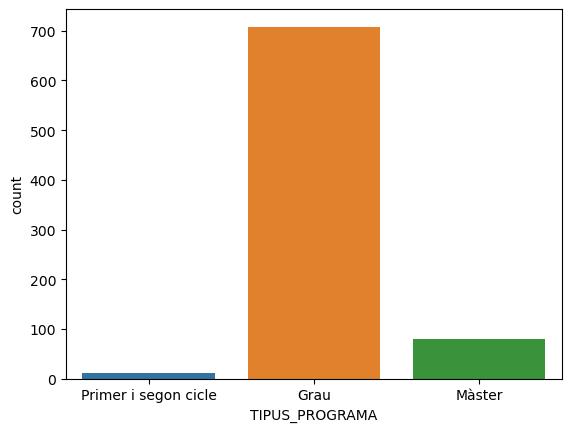

In [16]:
sns.countplot(x=df_graduates["TIPUS_PROGRAMA"])

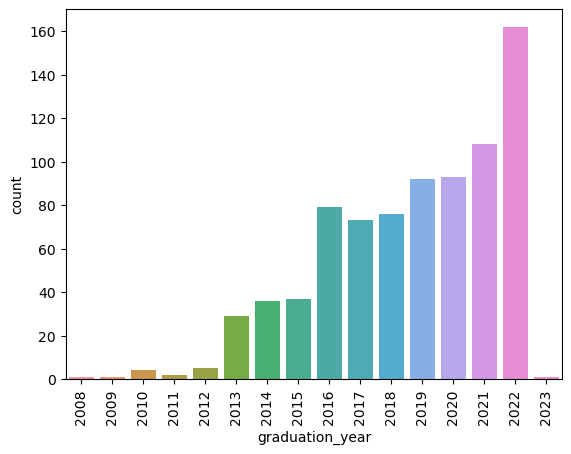

In [24]:
sns.countplot(x=df_graduates["graduation_year"]).tick_params(axis='x', rotation=90)

## Programs

In [37]:
df_programs = df_full["PROGRAMAS"]
df_programs.head()

,CODI_PRG,CODI_PLA,DENOM_PRG,CODI_ANY_ACAD
0,339,87,GRAU ADMINISTRACIÓ I DIRECCIÓ D'EMPRESES ...,910
1,505,87,GRAU ADMINISTRACIÓ I DIRECCIÓ D'EMPRESES 2010-...,1011
2,674,87,GRAU ADMINISTRACIÓ I DIRECCIÓ D'EMPRESES 2011-...,1112
3,798,87,GRAU EN ADMINISTRACIÓ I DIRECCIÓ D'EMPRESES 20...,1213
4,927,87,GRAU EN ADMINISTRACIÓ I DIRECCIÓ D'EMPRESES 20...,1314


## Estudiantes

In [74]:
df_students = df_full["QRY_ESTUDIANTS"]
df_students[df_students["Num_id"].apply(lambda x: x in est)]


,Num_id,Data_naix,Sexe,Nacionalitat,ViaAcces,Poblacio,OrigEst,Denom,Nom_pobl,Comarca,Provincia,Comunitat,Pais,EscolaAcces
0,100,1978-03-31,True,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,588,1979-03-06,False,62.0,NaN,74.0,2.0,CICLE FORMATIU,BARCELONA ...,13.0,8.0,11.0,ESP,IES EL PALAU
2,1700,1976-03-12,True,62.0,NaN,1330.0,NaN,NaN,SANTA PERPÈTUA DE MOGODA ...,40.0,8.0,11.0,ESP,NaN
3,3060,1977-03-24,True,62.0,NaN,74.0,2.0,CICLE FORMATIU,BARCELONA ...,13.0,8.0,11.0,ESP,ESCOLA DEL TREBALL
4,3063,1981-11-24,True,62.0,NaN,1410.0,2.0,CICLE FORMATIU,TERRASSA ...,40.0,8.0,11.0,ESP,CULTURA PRACTICA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,114531,1984-02-15,False,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2126,114532,1985-02-11,False,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,114533,1994-07-14,False,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,114534,1996-03-12,False,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Notas de estudiantes 

In [48]:
df_grades_graduated = df_full["QRY_MAT_EXP"][df_full["QRY_MAT_EXP"]["CODI_EST"].apply(lambda x: x in df_graduates["CODI_EST"])]
df_grades_graduated = df_grades_graduated[df_grades_graduated["TIPUS_CR"]=="OB00"]
df_grades_graduated

,CODI_PLA,CODI_EST,CODI_MAT,CODI_PRG,CODI_ANY_ACAD,CODI_TORN,CR,TIPUS_CR,DATA_BAIXA,Not_def_n,Not_def_d,Not_exp_n,Not_exp_d,Not_bloc_n,Not_bloc_d,Codi_upc,Denom
0,87,95,19343,1027,1415,2,6,OB00,NaN,97,EX,NaN,NaN,97.0,EX,801111,Dret fiscal II ...
1,87,95,19343,1027,1415,2,6,OB00,NaN,85,NO,NaN,NaN,85.0,NO,801106,Sociologia ...
2,87,95,19343,1027,1415,2,6,OB00,NaN,74,NO,NaN,NaN,74.0,NO,801125,Desenvolupament professional III ...
3,87,95,19343,1027,1415,2,6,OB00,NaN,72,NO,NaN,NaN,72.0,NO,801123,Desenvolupament professional I ...
4,87,95,20719,1182,1516,2,6,OB00,NaN,71,NO,NaN,NaN,71.0,NO,801134,Sistemes d'informació ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49881,210,218,64290,2639,2122,2,5,OB00,NaN,71,NO,NaN,NaN,71.0,NO,801529,Branding corporativo ...
49882,210,218,64290,2639,2122,2,5,OB00,NaN,62,AP,NaN,NaN,62.0,AP,801532,Estrategias de comunicación ...
49883,210,218,64290,2639,2122,2,5,OB00,NaN,76,NO,NaN,NaN,76.0,NO,801530,Cultura corporativa ...
49884,210,218,64290,2639,2122,2,5,OB00,NaN,68,AP,NaN,NaN,68.0,AP,801521,"Investigacion de mercados, gestión de la infor..."


KeyboardInterrupt: 

In [122]:
df_full["QRY_EST_x_MAT"] #.keys()

,CODI_EST,CODI_ANY_ACAD,CODI_PRG,CODI_MAT
0,100,1415,1027,19343
1,100,1516,1182,20719
2,588,1213,798,18413
3,588,1314,927,18696
4,588,1415,1027,19509
...,...,...,...,...
6309,114531,2122,2626,63872
6310,114532,2122,2626,64360
6311,114533,2122,2626,63814
6312,114534,2122,2639,63764
